In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path

# =========================
# Parameters (edit here)
# =========================
INPUT_CSV = "./Step2_processed_results.csv"
SAVE_PATH = "./Analysis"

POSTED_AT_COL = "posted_at"
SCORE_COL = "final_score"

DAYS_BACK = 3   # past 3 weeks
FIGSIZE = (14, 6)

SCORE_COLORS = {
    0: "#7f7f7f",  # gray
    1: "#d62728",  # red
    2: "#ff7f0e",  # orange
    3: "#f1c40f",  # yellow
    4: "#8bc34a",  # light green
    5: "#2ca02c",  # green
    6: "#006400",  # dark green
}

SCORES = [0, 1, 2, 3, 4, 6]
TARGET_SCORES = [3, 4, 6]

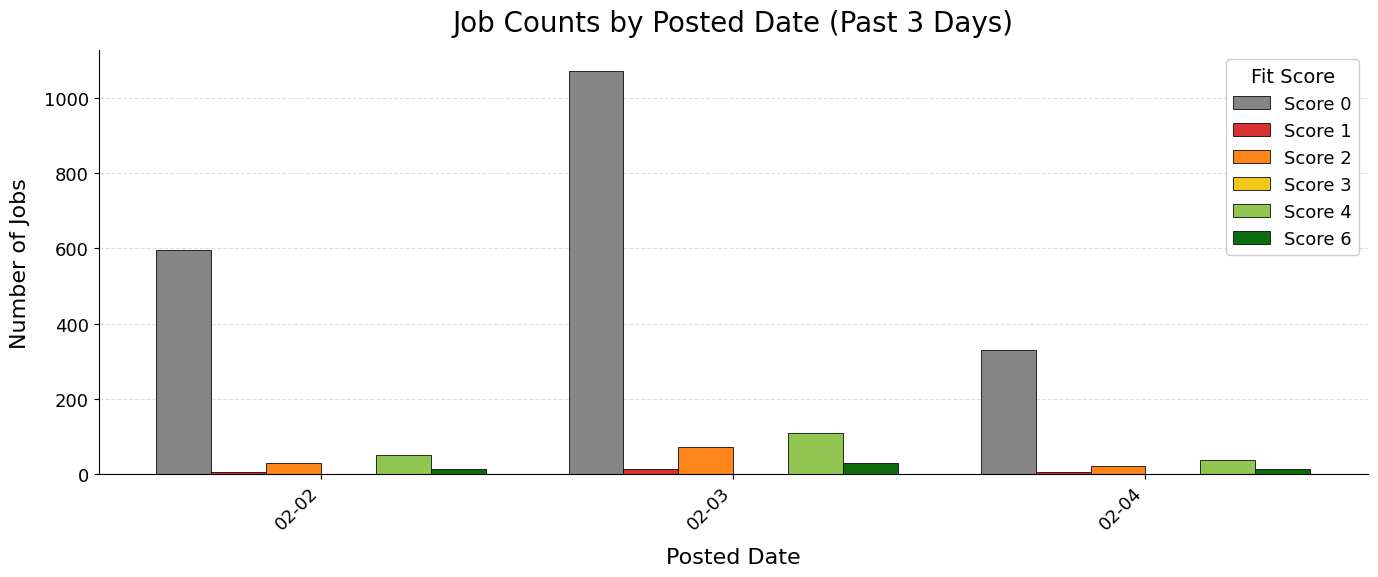


✅ Saved outputs to: /home/lilixiya/Desktop/LinkedIn-Easy-Apply-Bot/Analysis/2026-02-04_23-08-52
   - filtered.csv: /home/lilixiya/Desktop/LinkedIn-Easy-Apply-Bot/Analysis/2026-02-04_23-08-52/filtered.csv
   - pivot_counts.csv: /home/lilixiya/Desktop/LinkedIn-Easy-Apply-Bot/Analysis/2026-02-04_23-08-52/pivot_counts.csv
   - plot.png: /home/lilixiya/Desktop/LinkedIn-Easy-Apply-Bot/Analysis/2026-02-04_23-08-52/plot.png



In [ ]:
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ============================================================
# 0. Setup: Run directory + metadata logging
# ============================================================
RUN_TS = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path(SAVE_PATH) / RUN_TS
RUN_DIR.mkdir(parents=True, exist_ok=True)

meta_path = RUN_DIR / "run_meta.txt"
with open(meta_path, "w", encoding="utf-8") as f:
    f.write(f"RUN_TS={RUN_TS}\n")
    f.write(f"INPUT_CSV={INPUT_CSV}\n")
    f.write(f"DAYS_BACK={DAYS_BACK}\n")
    f.write(f"POSTED_AT_COL={POSTED_AT_COL}\n")
    f.write(f"SCORE_COL={SCORE_COL}\n")
    f.write(f"SCORES={SCORES}\n")


# ============================================================
# 1. Load & validate data
# ============================================================
input_path = Path(INPUT_CSV)
if not input_path.exists():
    raise FileNotFoundError(f"Input CSV not found: {input_path}")

df = pd.read_csv(input_path)

required_cols = [POSTED_AT_COL, SCORE_COL]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")


# ============================================================
# 2. Parse timestamp + clean rows
# ============================================================
df[POSTED_AT_COL] = pd.to_datetime(df[POSTED_AT_COL], errors="coerce")
df[SCORE_COL] = pd.to_numeric(df[SCORE_COL], errors="coerce")

df = df.dropna(subset=[POSTED_AT_COL, SCORE_COL]).copy()
df[SCORE_COL] = df[SCORE_COL].astype(int)


# ============================================================
# 3. Filter by time window (past DAYS_BACK days)
# ============================================================
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
start_date = today - timedelta(days=DAYS_BACK - 1)
end_date = today + timedelta(days=1)

df = df[(df[POSTED_AT_COL] >= start_date) & (df[POSTED_AT_COL] < end_date)].copy()
df["date"] = df[POSTED_AT_COL].dt.date

filtered_path = RUN_DIR / "filtered.csv"
df.to_csv(filtered_path, index=False)


# ============================================================
# 4. Aggregate: counts per day x score
# ============================================================
pivot = (
    df.groupby(["date", SCORE_COL])
      .size()
      .unstack(fill_value=0)
)

# Ensure score columns exist
for s in SCORES:
    if s not in pivot.columns:
        pivot[s] = 0

pivot = pivot[SCORES]

# Reindex full date range (include missing days)
all_dates = [(start_date + timedelta(days=i)).date() for i in range(DAYS_BACK)]
pivot = pivot.reindex(all_dates, fill_value=0)

pivot_path = RUN_DIR / "pivot_counts.csv"
pivot.to_csv(pivot_path, index=True)

# ============================================================
# 4.5 Ratio stats: % of scores 3/4/6 in total jobs
# ============================================================
total_jobs = len(df)

ratio_scores = [3, 4, 6]
ratio_counts = {s: int((df[SCORE_COL] == s).sum()) for s in ratio_scores}

ratio_total = sum(ratio_counts.values())
ratio_pct_total = ratio_total / total_jobs if total_jobs > 0 else 0.0

ratio_pct_each = {
    s: (ratio_counts[s] / total_jobs if total_jobs > 0 else 0.0)
    for s in ratio_scores
}

print("\n================ Ratio Summary ================")
print(f"Total jobs (filtered): {total_jobs}")
for s in ratio_scores:
    print(f"Score {s}: {ratio_counts[s]}  ({ratio_pct_each[s]*100:.2f}%)")
print(f"Score 3+4+6 total: {ratio_total}  ({ratio_pct_total*100:.2f}%)")
print("================================================\n")
# ============================================================
# 5. Plot: Conference-quality grouped bar chart
# ============================================================
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 20,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "legend.title_fontsize": 14,
})

fig, ax = plt.subplots(figsize=FIGSIZE)

x = np.arange(len(pivot.index))
n_scores = len(SCORES)
bar_width = min(0.8 / n_scores, 0.15)

offsets = {
    score: (i - (n_scores - 1) / 2) * bar_width
    for i, score in enumerate(SCORES)
}

for score in SCORES:
    ax.bar(
        x + offsets[score],
        pivot[score].values,
        width=bar_width,
        label=f"Score {score}",
        color=SCORE_COLORS.get(score, None),
        edgecolor="black",
        linewidth=0.6,
        alpha=0.95,
    )

# ---- axes formatting ----
ax.set_title(f"Job Counts by Posted Date (Past {DAYS_BACK} Days)", pad=14)
ax.set_xlabel("Posted Date", labelpad=10)
ax.set_ylabel("Number of Jobs", labelpad=10)

ax.set_xticks(x)
ax.set_xticklabels(
    [d.strftime("%m-%d") for d in pivot.index],
    rotation=45,
    ha="right",
)

# ---- grid: paper-style ----
ax.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.4)
ax.set_axisbelow(True)

# ---- remove top/right spines (paper look) ----
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ---- legend ----
ax.legend(
    title="Fit Score",
    loc="upper right",
    frameon=True,
    fancybox=True,
    framealpha=0.95,
)

plt.tight_layout()

plot_path = RUN_DIR / "plot.png"
fig.savefig(plot_path, dpi=300, bbox_inches="tight")

plt.show()

print(f"\n✅ Saved outputs to: {RUN_DIR}")
print(f"   - filtered.csv: {filtered_path}")
print(f"   - pivot_counts.csv: {pivot_path}")
print(f"   - plot.png: {plot_path}\n")



/tmp/ipykernel_973539/717584141.py:192: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df


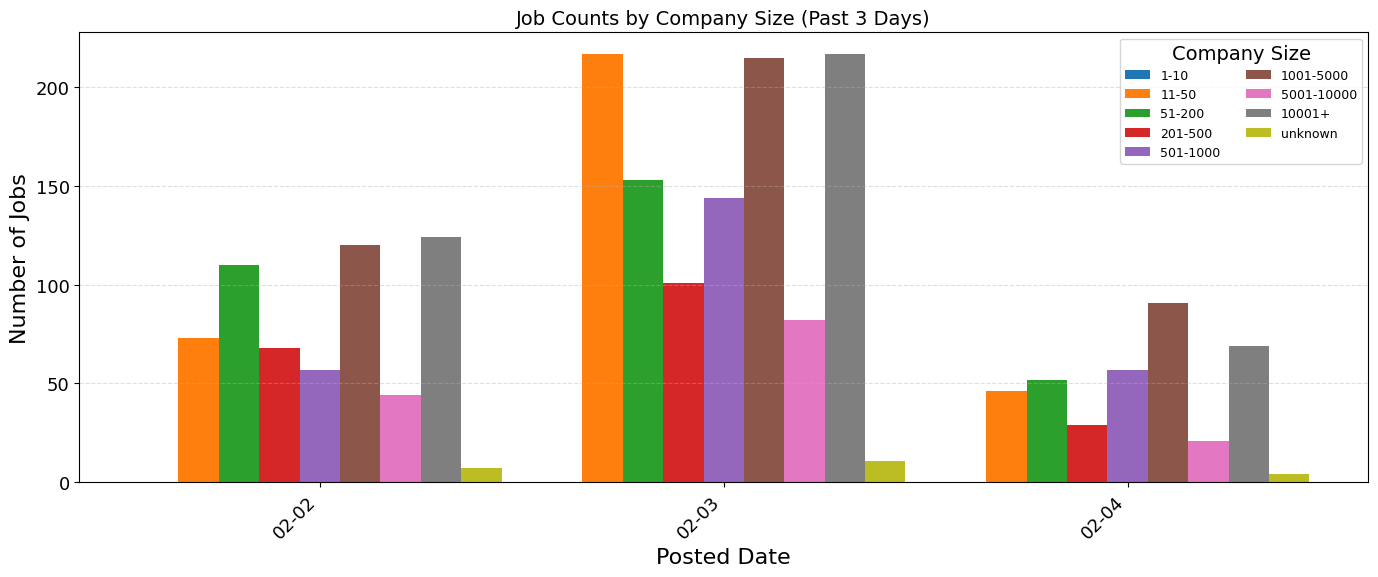

In [31]:
from pathlib import Path
from datetime import datetime, timedelta
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Config (NEW): company size
# =========================
# 你可以直接指定一个列名（如果你知道你csv里叫啥）
# COMPANY_SIZE_COL = "company_size"

# 或者给候选列名，让代码自动挑第一个存在的
COMPANY_SIZE_COL_CANDIDATES = [
    "company_size",
    "companySize",
    "company_employees",
    "companyEmployees",
    "employees",
    "employee_count",
    "employeeCount",
    "size",
]

# 统一 bucket 顺序（你也可以按你喜好改）
SIZE_BUCKET_ORDER = [
    "1-10",
    "11-50",
    "51-200",
    "201-500",
    "501-1000",
    "1001-5000",
    "5001-10000",
    "10001+",
    "unknown",
]

def _pick_first_existing_col(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        f"Missing company size column. Tried: {candidates}. "
        f"Available columns: {list(df.columns)}"
    )

def _normalize_company_size_bucket(x) -> str:
    """
    将各种 company size 表达归一化为：
    1-10, 11-50, 51-200, 201-500, 501-1000, 1001-5000, 5001-10000, 10001+, unknown
    """
    if pd.isna(x):
        return "unknown"
    s = str(x).strip().lower()

    if s == "" or s in {"nan", "none", "null"}:
        return "unknown"

    # 常见格式： "1-10 employees", "11-50", "1001-5000 employees"
    # 也可能： "10,001+ employees", "10000+", "10001+"
    s = s.replace("employees", "").replace("employee", "").replace(",", "").strip()

    # 处理 10001+ / 10000+ / 10k+
    m_plus = re.search(r"(\d+)\s*\+", s)
    if m_plus:
        n = int(m_plus.group(1))
        # 统一到 10001+
        return "10001+" if n >= 10001 else f"{n}+"

    # 处理区间：1001-5000
    m_rng = re.search(r"(\d+)\s*-\s*(\d+)", s)
    if m_rng:
        a = int(m_rng.group(1))
        b = int(m_rng.group(2))
        # 用常见 bucket 映射；不在表里的就按原样返回
        key = f"{a}-{b}"
        if key in set(SIZE_BUCKET_ORDER):
            return key
        return key

    # 处理纯数字（比如 "300"），粗略落 bucket
    m_num = re.search(r"^\d+$", s)
    if m_num:
        n = int(s)
        if n <= 10:
            return "1-10"
        elif n <= 50:
            return "11-50"
        elif n <= 200:
            return "51-200"
        elif n <= 500:
            return "201-500"
        elif n <= 1000:
            return "501-1000"
        elif n <= 5000:
            return "1001-5000"
        elif n <= 10000:
            return "5001-10000"
        else:
            return "10001+"

    return "unknown"


# =========================
# Run folder under SAVE_PATH (NEW)
# =========================
RUN_TS = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path(SAVE_PATH) / RUN_TS
RUN_DIR.mkdir(parents=True, exist_ok=True)

# 可选：把本次运行的关键参数也落个档
with open(RUN_DIR / "run_meta.txt", "w", encoding="utf-8") as f:
    f.write(f"RUN_TS={RUN_TS}\n")
    f.write(f"INPUT_CSV={INPUT_CSV}\n")
    f.write(f"DAYS_BACK={DAYS_BACK}\n")
    f.write(f"POSTED_AT_COL={POSTED_AT_COL}\n")
    f.write(f"SCORE_COL={SCORE_COL}\n")
    f.write(f"SCORES={SCORES}\n")
    f.write(f"COMPANY_SIZE_COL_CANDIDATES={COMPANY_SIZE_COL_CANDIDATES}\n")
    f.write(f"SIZE_BUCKET_ORDER={SIZE_BUCKET_ORDER}\n")

# =========================
# Load data
# =========================
if not Path(INPUT_CSV).exists():
    raise FileNotFoundError(INPUT_CSV)

df = pd.read_csv(INPUT_CSV)

# 必要列检查
for col in [POSTED_AT_COL, SCORE_COL]:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# company size 列：自动选择
# 如果你已手动指定 COMPANY_SIZE_COL，就用它；否则从候选里挑
if "COMPANY_SIZE_COL" in globals() and isinstance(COMPANY_SIZE_COL, str) and COMPANY_SIZE_COL.strip():
    if COMPANY_SIZE_COL not in df.columns:
        raise ValueError(f"COMPANY_SIZE_COL='{COMPANY_SIZE_COL}' not found in columns: {list(df.columns)}")
    COMPANY_SIZE_COL_RESOLVED = COMPANY_SIZE_COL
else:
    COMPANY_SIZE_COL_RESOLVED = _pick_first_existing_col(df, COMPANY_SIZE_COL_CANDIDATES)

# =========================
# Parse datetime + clean
# =========================
df[POSTED_AT_COL] = pd.to_datetime(df[POSTED_AT_COL], errors="coerce")
df = df.dropna(subset=[POSTED_AT_COL, SCORE_COL])

# score int
df[SCORE_COL] = pd.to_numeric(df[SCORE_COL], errors="coerce")
df = df.dropna(subset=[SCORE_COL])
df[SCORE_COL] = df[SCORE_COL].astype(int)

# =========================
# Filter time window
# =========================
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
start_date = today - timedelta(days=DAYS_BACK - 1)

df = df[
    (df[POSTED_AT_COL] >= start_date) &
    (df[POSTED_AT_COL] < today + timedelta(days=1))
].copy()

df["date"] = df[POSTED_AT_COL].dt.date

# =========================
# Normalize company size (NEW)
# =========================
df["company_size_bucket"] = df[COMPANY_SIZE_COL_RESOLVED].apply(_normalize_company_size_bucket)

# 强制 bucket 为分类并按固定顺序
df["company_size_bucket"] = pd.Categorical(
    df["company_size_bucket"],
    categories=SIZE_BUCKET_ORDER,
    ordered=True
)

# =========================
# Save filtered df (NEW)
# =========================
df.to_csv(RUN_DIR / "filtered.csv", index=False)

# =========================
# Aggregate counts by date + company_size_bucket (NEW)
# =========================
pivot_size = (
    df
    .groupby(["date", "company_size_bucket"])
    .size()
    .unstack(fill_value=0)
)

# 确保所有 bucket 都存在
for b in SIZE_BUCKET_ORDER:
    if b not in pivot_size.columns:
        pivot_size[b] = 0
pivot_size = pivot_size[SIZE_BUCKET_ORDER]

# Reindex full date range (include empty days)
all_dates = [
    (start_date + timedelta(days=i)).date()
    for i in range(DAYS_BACK)
]
pivot_size = pivot_size.reindex(all_dates, fill_value=0)

# =========================
# Save pivot (NEW)
# =========================
pivot_size.to_csv(RUN_DIR / "pivot_company_size.csv", index=True)

# =========================
# Plot (GROUPED BAR): company size counts per day (NEW)
# =========================
fig, ax = plt.subplots(figsize=FIGSIZE)

x = np.arange(len(pivot_size.index))
k = len(SIZE_BUCKET_ORDER)
bar_width = min(0.9 / max(k, 1), 0.12)  # 控制柱子宽度，bucket多时别太挤

# 居中偏移：[-(k-1)/2, ..., +(k-1)/2] * bar_width
offsets = (np.arange(k) - (k - 1) / 2.0) * bar_width

for i, bucket in enumerate(SIZE_BUCKET_ORDER):
    ax.bar(
        x + offsets[i],
        pivot_size[bucket].values,
        width=bar_width,
        label=bucket,
    )

ax.set_title(f"Job Counts by Company Size (Past {DAYS_BACK} Days)", fontsize=14)
ax.set_xlabel("Posted Date")
ax.set_ylabel("Number of Jobs")

ax.set_xticks(x)
ax.set_xticklabels(
    [d.strftime("%m-%d") for d in pivot_size.index],
    rotation=45,
    ha="right",
)

ax.legend(title="Company Size", ncol=2, fontsize=9)
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

# =========================
# Save plot (NEW)
# =========================
fig.savefig(RUN_DIR / "plot_company_size.png", dpi=200, bbox_inches="tight")
plt.show()


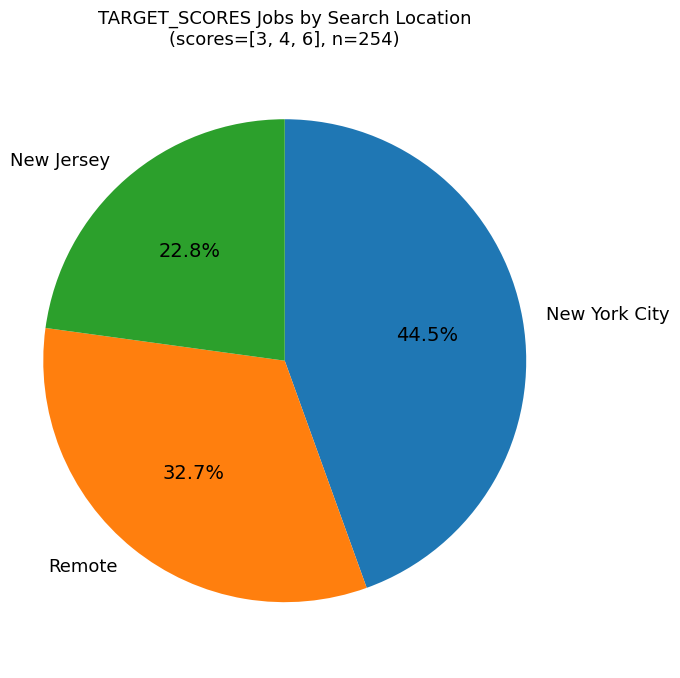

📁 Saved pie chart: /home/lilixiya/Desktop/LinkedIn-Easy-Apply-Bot/Analysis/2026-02-04_23-08-53/pie_search_location_target_scores.png


In [32]:
## =========================
# Pie chart: TARGET_SCORES by search_location (NEW)
# =========================
SEARCH_LOC_COL = "search_location"   # 如果列名不同，在这里改
TARGET_SCORES_SET = set(TARGET_SCORES)

if SEARCH_LOC_COL not in df.columns:
    print(f"⚠️ Column '{SEARCH_LOC_COL}' not found in df, skip pie chart.")
else:
    # 1) 仅保留 TARGET_SCORES
    df_sel = df[df[SCORE_COL].isin(TARGET_SCORES_SET)].copy()

    # 2) 按 search_location 统计数量
    loc_counts = (
        df_sel[SEARCH_LOC_COL]
        .fillna("Unknown")
        .astype(str)
        .replace({"nan": "Unknown", "None": "Unknown", "": "Unknown"})
        .value_counts()
    )

    # 3) 类别过多会很乱：合并小类到 Other（可调）
    TOPK = 8
    if len(loc_counts) > TOPK:
        top = loc_counts.iloc[:TOPK]
        other_sum = loc_counts.iloc[TOPK:].sum()
        loc_counts = top.copy()
        loc_counts.loc["Other"] = int(other_sum)

    # 4) 画饼图
    fig_pie, ax_pie = plt.subplots(figsize=(7, 7))
    ax_pie.pie(
        loc_counts.values,
        labels=loc_counts.index,
        autopct=lambda p: f"{p:.1f}%" if p >= 3 else "",  # 太小的不显示
        startangle=90,
        counterclock=False,
    )
    ax_pie.set_title(
        f"TARGET_SCORES Jobs by Search Location\n(scores={sorted(TARGET_SCORES_SET)}, n={len(df_sel)})",
        fontsize=13
    )
    ax_pie.axis("equal")  # 保证是圆

    plt.tight_layout()

    # 5) 保存
    pie_path = RUN_DIR / "pie_search_location_target_scores.png"
    fig_pie.savefig(pie_path, dpi=200, bbox_inches="tight")
    plt.show()

    print(f"📁 Saved pie chart: {pie_path}")


In [33]:
# =========================
# Filter by score list
# =========================
df[SCORE_COL] = pd.to_numeric(df[SCORE_COL], errors="coerce")

TARGET_SCORES_SET = set(TARGET_SCORES)
df_sel = df[df[SCORE_COL].isin(TARGET_SCORES_SET)].copy()

msg = f"\n✅ Total jobs with score in {sorted(TARGET_SCORES_SET)}: {len(df_sel)}\n"
print(msg)

# =========================
# Save selected jobs (NEW)
# =========================
df_sel.to_csv(RUN_DIR / "selected_jobs.csv", index=False)

# =========================
# Filter by score list
# =========================
df[SCORE_COL] = pd.to_numeric(df[SCORE_COL], errors="coerce")

TARGET_SCORES_SET = set(TARGET_SCORES)
df_sel = df[df[SCORE_COL].isin(TARGET_SCORES_SET)].copy()

# =========================
# NEW: sort by score desc so high scores come first (PDF/TXT follow this order)
# =========================
df_sel["_score_sort"] = pd.to_numeric(df_sel[SCORE_COL], errors="coerce").fillna(-1)
# 可选：同分时按 posted_at 再排序（如果有）
if "posted_at" in df_sel.columns or POSTED_AT_COL in df_sel.columns:
    pa_col = "posted_at" if "posted_at" in df_sel.columns else POSTED_AT_COL
    df_sel["_posted_sort"] = df_sel[pa_col].astype(str)
    df_sel = df_sel.sort_values(by=["_score_sort", "_posted_sort"], ascending=[False, False])
else:
    df_sel = df_sel.sort_values(by=["_score_sort"], ascending=[False])

# 清理辅助列（避免写进csv/pdf）
df_sel.drop(columns=[c for c in ["_posted_sort"] if c in df_sel.columns], inplace=True)

msg = f"\n✅ Total jobs with score in {sorted(TARGET_SCORES_SET)}: {len(df_sel)}\n"
print(msg)

# =========================
# Save selected jobs (NEW)
# =========================
# 也会按高分在前保存
df_sel.drop(columns=["_score_sort"], inplace=True, errors="ignore")
df_sel.to_csv(RUN_DIR / "selected_jobs.csv", index=False)

# =========================
# Pretty print (TXT + PDF)
# =========================
from pathlib import Path

def _pick_first(row, keys, default=""):
    for k in keys:
        if k in row and pd.notna(row[k]) and str(row[k]).strip() != "":
            return str(row[k])
    return default

def _safe_str(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    return str(x)

def _fmt_easy_apply(x):
    s = str(x).strip().lower()
    if s in {"1", "true", "yes", "y", "t"}:
        return "Yes"
    if s in {"0", "false", "no", "n", "f"}:
        return "No"
    if s in {"nan", "none", ""}:
        return ""
    return str(x)

# ----- Save TXT (nicer spacing) -----
pretty_txt_path = RUN_DIR / "selected_jobs_pretty.txt"

header_msg = f"✅ Total jobs with score in {sorted(TARGET_SCORES_SET)}: {len(df_sel)}\n"
print("\n" + header_msg)

SEP = "\n" + ("=" * 92) + "\n"
SUBSEP = "-" * 92

with open(pretty_txt_path, "w", encoding="utf-8") as f:
    f.write(header_msg)
    f.write(SUBSEP + "\n\n")

    # ✅ already sorted: high score first
    for idx, (_, row) in enumerate(df_sel.iterrows(), start=1):
        job_id = _pick_first(row, ["jobID", "job_id", "id"])
        title = _pick_first(row, ["title"])
        company = _pick_first(row, ["company"])
        location = _pick_first(row, ["search_location"])
        posted_at = _pick_first(row, ["posted_at", POSTED_AT_COL])
        url = _pick_first(row, ["job_url", "url"])
        score = _pick_first(row, ["final_score", SCORE_COL])

        # ✅ Easy Apply (from easy_apply col, fallback to has_easy_apply)
        easy_apply_raw = _pick_first(row, ["easy_apply", "has_easy_apply"])
        easy_apply = _fmt_easy_apply(easy_apply_raw)

        llm_jd_summary = _pick_first(row, ["llm_jd_summary", "llm_jd_eval", "jd_summary", "llm_summary"])
        fit_reason = _pick_first(row, ["fit_reason"])

        block_lines = []
        block_lines.append(f"[{idx}] {title}  |  {company}")
        block_lines.append(f"JobID           : {job_id}")
        block_lines.append(f"Search Location : {location}")
        block_lines.append(f"Posted At       : {posted_at}")
        if easy_apply:
            block_lines.append(f"Easy Apply      : {easy_apply}")
        block_lines.append(f"URL             : {url}")
        block_lines.append(f"Score           : {score}")

        # LLM—JD—summary（如果有）
        if llm_jd_summary.strip():
            block_lines.append("")
            block_lines.append("LLM—JD—summary:")
            block_lines.append(_safe_str(llm_jd_summary).strip())

        # Why this score
        if fit_reason.strip():
            block_lines.append("")
            block_lines.append("Why this score:")
            block_lines.append(_safe_str(fit_reason).strip())

        block = SEP + "\n".join(block_lines) + "\n" + SEP + "\n\n\n"  # <-- 两个job之间空更大

        print(block, end="")
        f.write(block)

# ----- Save PDF (bigger font + prettier layout + hyperlink URL) -----
# pip install reportlab
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
from xml.sax.saxutils import escape as _xml_escape

pretty_pdf_path = RUN_DIR / "selected_jobs_pretty.pdf"

base_styles = getSampleStyleSheet()

# Bigger, nicer styles
title_style = ParagraphStyle(
    "MyTitle",
    parent=base_styles["Title"],
    fontSize=22,
    leading=26,
    spaceAfter=12,
)
h_style = ParagraphStyle(
    "MyH2",
    parent=base_styles["Heading2"],
    fontSize=15,
    leading=18,
    spaceBefore=6,
    spaceAfter=8,
)
h3_style = ParagraphStyle(
    "MyH3",
    parent=base_styles["Heading3"],
    fontSize=13,
    leading=16,
    spaceBefore=6,
    spaceAfter=6,
)
label_style = ParagraphStyle(
    "MyBody",
    parent=base_styles["BodyText"],
    fontSize=11.5,
    leading=15,
    spaceAfter=6,
)

doc = SimpleDocTemplate(
    str(pretty_pdf_path),
    pagesize=letter,
    rightMargin=0.8 * inch,
    leftMargin=0.8 * inch,
    topMargin=0.8 * inch,
    bottomMargin=0.8 * inch,
)

story = []
story.append(Paragraph("Selected Jobs Report", title_style))
story.append(Spacer(1, 0.10 * inch))
story.append(Paragraph(_safe_str(header_msg).replace("\n", "<br/>"), label_style))
story.append(Spacer(1, 0.15 * inch))

# ✅ already sorted: high score first
for i, (_, row) in enumerate(df_sel.iterrows(), start=1):
    job_id = _pick_first(row, ["jobID", "job_id", "id"])
    title = _pick_first(row, ["title"])
    company = _pick_first(row, ["company"])
    location = _pick_first(row, ["search_location"])
    posted_at = _pick_first(row, ["posted_at", POSTED_AT_COL])
    url = _pick_first(row, ["job_url", "url"])
    score = _pick_first(row, ["final_score", SCORE_COL])

    # Easy Apply from easy_apply col (fallback to has_easy_apply)
    easy_apply_raw = _pick_first(row, ["easy_apply", "has_easy_apply"])
    easy_apply = _fmt_easy_apply(easy_apply_raw)

    llm_jd_summary = _pick_first(row, ["llm_jd_summary", "llm_jd_eval", "jd_summary", "llm_summary"])
    fit_reason = _pick_first(row, ["fit_reason"])

    story.append(Paragraph(f"[{i}] {title} — {company}", h_style))
    story.append(Spacer(1, 0.08 * inch))

    # URL as clickable hyperlink
    url_href = url.strip()
    if url_href:
        url_cell = Paragraph(
            f'<link href="{_xml_escape(url_href)}" color="blue">{_xml_escape(url_href)}</link>',
            label_style
        )
    else:
        url_cell = ""

    # Prettier: use a 2-col table
    info_rows = [
        ["JobID", job_id],
        ["Search Location", location],
        ["Posted At", posted_at],
        ["Easy Apply", easy_apply],
        ["URL", url_cell],
        ["Score", score],
    ]

    # Drop empty values for cleaner output
    def _is_empty(v):
        if v is None:
            return True
        if isinstance(v, str) and v.strip() == "":
            return True
        return False

    info_rows = [r for r in info_rows if not _is_empty(r[1])]

    table = Table(
        info_rows,
        colWidths=[1.55 * inch, 5.25 * inch],
        hAlign="LEFT",
    )
    table.setStyle(TableStyle([
        ("FONTNAME", (0, 0), (-1, -1), "Helvetica"),
        ("FONTSIZE", (0, 0), (-1, -1), 11.5),
        ("LEADING", (0, 0), (-1, -1), 14),
        ("VALIGN", (0, 0), (-1, -1), "TOP"),

        ("BACKGROUND", (0, 0), (0, -1), colors.whitesmoke),
        ("TEXTCOLOR", (0, 0), (0, -1), colors.black),

        ("BOX", (0, 0), (-1, -1), 0.6, colors.lightgrey),
        ("LINEBELOW", (0, 0), (-1, -1), 0.25, colors.lightgrey),

        ("LEFTPADDING", (0, 0), (-1, -1), 6),
        ("RIGHTPADDING", (0, 0), (-1, -1), 6),
        ("TOPPADDING", (0, 0), (-1, -1), 5),
        ("BOTTOMPADDING", (0, 0), (-1, -1), 5),
    ]))

    story.append(table)
    story.append(Spacer(1, 0.14 * inch))

    if llm_jd_summary.strip():
        story.append(Paragraph("LLM—JD—summary", h3_style))
        story.append(Paragraph(_safe_str(llm_jd_summary).replace("\n", "<br/>"), label_style))
        story.append(Spacer(1, 0.12 * inch))

    if fit_reason.strip():
        story.append(Paragraph("Why this score", h3_style))
        story.append(Paragraph(_safe_str(fit_reason).replace("\n", "<br/>"), label_style))
        story.append(Spacer(1, 0.10 * inch))

    story.append(PageBreak())

doc.build(story)

print(f"📁 Saved PDF: {pretty_pdf_path}")



✅ Total jobs with score in [3, 4, 6]: 254


✅ Total jobs with score in [3, 4, 6]: 254


✅ Total jobs with score in [3, 4, 6]: 254


[1] Data Scientist (Python,NLP,LLM,Gen AI) : Remote Opportunity : Long-Term Contract  |  Jobs via Dice
JobID           : 4368929036
Search Location : New York City
Posted At       : 2026-02-04 20:23:54
Easy Apply      : Yes
URL             : https://www.linkedin.com/jobs/view/4368929036
Score           : 6

LLM—JD—summary:
- Role: Data Scientist focused on Python, NLP, LLMs, and Generative AI
- Remote, long-term contract position
- Requires 5–6 years total experience, with 2–3 years specifically in NLP/LLM/Gen AI
- Needs hands-on experience fine-tuning LLMs (e.g., GPT, BERT, Llama)
- Expects strong NLP skills: tokenization, NER, sentiment analysis, etc.
- Requires experience with AWS architecture and services
- Values software engineering fundamentals and Agile development
- Mentions use of TensorFlow, PyTorch, Hugging Face Transformers





[2] Research 

📁 Saved PDF: /home/lilixiya/Desktop/LinkedIn-Easy-Apply-Bot/Analysis/2026-02-04_23-08-53/selected_jobs_pretty.pdf


In [ ]:
# =========================
# NEW: Filter by (score > 1) AND (company size > 500)
#      AND merge counting by (title + company)
#      BUT PDF/TXT show ALL listings in each merged group
# =========================
import re
import numpy as np
import pandas as pd
from pathlib import Path

# -------------------------
# (A) Required variables fallback
# -------------------------
# Assumes df exists in notebook.
# If not, set df by reading csv before running this cell.

if "RUN_DIR" not in globals():
    RUN_DIR = Path("./run_outputs").resolve()
RUN_DIR = Path(RUN_DIR)
RUN_DIR.mkdir(parents=True, exist_ok=True)

if "SCORE_COL" not in globals():
    _score_candidates = ["final_score", "score", "Score", "fitScore"]
    SCORE_COL = next((c for c in _score_candidates if c in df.columns), None)
    if SCORE_COL is None:
        raise ValueError(f"Missing SCORE_COL and cannot infer. Available columns: {list(df.columns)}")

# POSTED_AT_COL optional
if "POSTED_AT_COL" not in globals():
    _posted_candidates = ["posted_at", "postedAt", "date_posted", "datePosted", "posted_date", "postedDate"]
    POSTED_AT_COL = next((c for c in _posted_candidates if c in df.columns), None)

# -------------------------
# (B) resolve company size column
# -------------------------
COMPANY_SIZE_COL_CANDIDATES = [
    "company_size",
    "companySize",
    "company_employees",
    "companyEmployees",
    "employees",
    "employee_count",
    "employeeCount",
    "size",
]

def _pick_first_existing_col(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(
        f"Missing company size column. Tried: {candidates}. "
        f"Available columns: {list(df.columns)}"
    )

def _normalize_company_size_bucket(x) -> str:
    if pd.isna(x):
        return "unknown"
    s = str(x).strip().lower()
    if s == "" or s in {"nan", "none", "null"}:
        return "unknown"

    s = s.replace("employees", "").replace("employee", "").replace(",", "").strip()

    # "10001+"
    m_plus = re.search(r"(\d+)\s*\+", s)
    if m_plus:
        n = int(m_plus.group(1))
        return "10001+" if n >= 10001 else f"{n}+"

    # "1001-5000"
    m_rng = re.search(r"(\d+)\s*-\s*(\d+)", s)
    if m_rng:
        a = int(m_rng.group(1))
        b = int(m_rng.group(2))
        return f"{a}-{b}"

    # pure number like "300"
    if re.fullmatch(r"\d+", s):
        n = int(s)
        if n <= 10:
            return "1-10"
        elif n <= 50:
            return "11-50"
        elif n <= 200:
            return "51-200"
        elif n <= 500:
            return "201-500"
        elif n <= 1000:
            return "501-1000"
        elif n <= 5000:
            return "1001-5000"
        elif n <= 10000:
            return "5001-10000"
        else:
            return "10001+"

    return "unknown"

SIZE_BUCKET_ORDER = [
    "1-10", "11-50", "51-200", "201-500",
    "501-1000", "1001-5000", "5001-10000", "10001+",
    "unknown",
]
LARGE_COMPANY_BUCKETS = ["501-1000", "1001-5000", "5001-10000", "10001+"]

COMPANY_SIZE_COL = _pick_first_existing_col(df, COMPANY_SIZE_COL_CANDIDATES)

# bucketize
df = df.copy()
df["company_size_bucket"] = df[COMPANY_SIZE_COL].apply(_normalize_company_size_bucket)
df["company_size_bucket"] = pd.Categorical(df["company_size_bucket"], categories=SIZE_BUCKET_ORDER, ordered=True)

# -------------------------
# (C) score filter
# -------------------------
df[SCORE_COL] = pd.to_numeric(df[SCORE_COL], errors="coerce")

df_sel = df[
    (df[SCORE_COL] >= min(TARGET_SCORES)) &
    (df["company_size_bucket"].isin(LARGE_COMPANY_BUCKETS))
].copy()

# -------------------------
# (D) sort per-listing
# -------------------------
df_sel["_score_sort"] = pd.to_numeric(df_sel[SCORE_COL], errors="coerce").fillna(-1)

HAS_POSTED = (POSTED_AT_COL is not None) and (POSTED_AT_COL in df_sel.columns)
if HAS_POSTED:
    df_sel["_posted_sort"] = pd.to_datetime(df_sel[POSTED_AT_COL], errors="coerce")
    df_sel = df_sel.sort_values(by=["_score_sort", "_posted_sort"], ascending=[False, False])
else:
    df_sel = df_sel.sort_values(by=["_score_sort"], ascending=[False])

# -------------------------
# (E) Merge counting by (title + company)
# -------------------------
def _norm_key(x) -> str:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    return str(x).strip().lower()

if "title" not in df_sel.columns or "company" not in df_sel.columns:
    raise ValueError(f"Need columns 'title' and 'company' for merging, but got: {list(df_sel.columns)}")

df_sel["_title_norm"] = df_sel["title"].apply(_norm_key)
df_sel["_company_norm"] = df_sel["company"].apply(_norm_key)
df_sel["_tc_key"] = df_sel["_title_norm"] + "||" + df_sel["_company_norm"]

if HAS_POSTED:
    df_grp = (
        df_sel.groupby("_tc_key", as_index=False)
        .agg(
            _tc_key=("_tc_key", "first"),
            title=("title", "first"),
            company=("company", "first"),
            max_score=("_score_sort", "max"),
            latest_posted=("_posted_sort", "max"),
            n_listings=("title", "size"),
        )
        .sort_values(by=["max_score", "latest_posted"], ascending=[False, False])
    )
else:
    df_grp = (
        df_sel.groupby("_tc_key", as_index=False)
        .agg(
            _tc_key=("_tc_key", "first"),
            title=("title", "first"),
            company=("company", "first"),
            max_score=("_score_sort", "max"),
            n_listings=("title", "size"),
        )
        .sort_values(by=["max_score"], ascending=[False])
    )

merged_count = len(df_grp)
header_msg = f"✅ Total job groups: {merged_count}\n"
print("\n" + header_msg)

# -------------------------
# (F) Save CSVs
# -------------------------
raw_csv_path = RUN_DIR / "selected_jobs_score_gt1_company_gt500.csv"
merged_csv_path = RUN_DIR / "selected_jobs_score_gt1_company_gt500_MERGED.csv"

df_sel_raw = df_sel.drop(
    columns=[c for c in ["_score_sort", "_posted_sort", "_title_norm", "_company_norm", "_tc_key"] if c in df_sel.columns],
    errors="ignore",
)
df_sel_raw.to_csv(raw_csv_path, index=False)
df_grp.to_csv(merged_csv_path, index=False)

# -------------------------
# (G) Pretty print helpers
# -------------------------
def _pick_first(row, keys, default=""):
    for k in keys:
        if k and (k in row) and pd.notna(row[k]) and str(row[k]).strip() != "":
            return str(row[k])
    return default

def _safe_str(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return ""
    return str(x)

def _fmt_easy_apply(x):
    s = str(x).strip().lower()
    if s in {"1", "true", "yes", "y", "t"}:
        return "Yes"
    if s in {"0", "false", "no", "n", "f"}:
        return "No"
    if s in {"nan", "none", ""}:
        return ""
    return str(x)

def _uniq_keep_order(seq):
    seen = set()
    out = []
    for v in seq:
        if v is None:
            continue
        s = str(v).strip()
        if s == "" or s.lower() in {"nan", "none", "null"}:
            continue
        if s not in seen:
            seen.add(s)
            out.append(s)
    return out

# -------------------------
# (H) Save TXT (MERGED, show ALL listings)  <-- FIXED: iterrows
# -------------------------
pretty_txt_path = RUN_DIR / "selected_jobs_score_gt1_company_gt500_MERGED.txt"

SEP = "\n" + ("=" * 92) + "\n"
SUBSEP = "-" * 92

with open(pretty_txt_path, "w", encoding="utf-8") as f:
    f.write(header_msg)
    f.write(SUBSEP + "\n\n")

    for idx, (_, g) in enumerate(df_grp.iterrows(), start=1):
        tc_key = g["_tc_key"]
        sub = df_sel[df_sel["_tc_key"] == tc_key].copy()

        if HAS_POSTED and "_posted_sort" in sub.columns:
            sub = sub.sort_values(by=["_score_sort", "_posted_sort"], ascending=[False, False])
        else:
            sub = sub.sort_values(by=["_score_sort"], ascending=[False])

        title = _safe_str(g.get("title", ""))
        company = _safe_str(g.get("company", ""))
        max_score = _safe_str(g.get("max_score", ""))

        company_sizes = _uniq_keep_order(sub.apply(lambda r: _pick_first(r, [COMPANY_SIZE_COL, "company_size_bucket"]), axis=1).tolist())
        locations = _uniq_keep_order(sub.apply(lambda r: _pick_first(r, ["search_location"]), axis=1).tolist())
        posted_list = _uniq_keep_order(
            sub.apply(lambda r: _pick_first(r, [POSTED_AT_COL] if HAS_POSTED else ["posted_at"]), axis=1).tolist()
        ) if HAS_POSTED else []

        block_lines = []
        block_lines.append(f"[{idx}] {title}  |  {company}   (listings: {len(sub)})")
        if company_sizes:
            block_lines.append(f"Company Size(s) : {', '.join(company_sizes)}")
        if locations:
            block_lines.append(f"Location(s)     : {', '.join(locations)}")
        if posted_list:
            block_lines.append(f"Posted At(s)    : {', '.join(posted_list)}")
        block_lines.append(f"Max Score       : {max_score}")

        block_lines.append("")
        block_lines.append("Listings:")
        for j, (_, row) in enumerate(sub.iterrows(), start=1):
            job_id = _pick_first(row, ["jobID", "job_id", "id"])
            posted_at = _pick_first(row, [POSTED_AT_COL] if HAS_POSTED else ["posted_at"])
            location = _pick_first(row, ["search_location"])
            url = _pick_first(row, ["job_url", "url"])
            score = _pick_first(row, ["final_score", SCORE_COL])
            company_size = _pick_first(row, [COMPANY_SIZE_COL, "company_size_bucket"])

            easy_apply_raw = _pick_first(row, ["easy_apply", "has_easy_apply"])
            easy_apply = _fmt_easy_apply(easy_apply_raw)

            line = f"  ({j}) JobID={job_id} | Score={score} | PostedAt={posted_at} | Loc={location} | Size={company_size}"
            if easy_apply:
                line += f" | EasyApply={easy_apply}"
            block_lines.append(line)
            if url.strip():
                block_lines.append(f"      URL={url}")

            llm_jd_summary = _pick_first(row, ["llm_jd_summary", "llm_jd_eval", "jd_summary", "llm_summary"])
            fit_reason = _pick_first(row, ["fit_reason"])

            if _safe_str(llm_jd_summary).strip():
                block_lines.append("      LLM—JD—summary:")
                block_lines.append("      " + _safe_str(llm_jd_summary).replace("\n", "\n      ").strip())

            if _safe_str(fit_reason).strip():
                block_lines.append("      Why this score:")
                block_lines.append("      " + _safe_str(fit_reason).replace("\n", "\n      ").strip())

        block = SEP + "\n".join(block_lines) + "\n" + SEP + "\n\n\n"
        print(block, end="")
        f.write(block)
# -------------------------
# (I) Save PDF (MERGED; hyperlink URL; show ALL listing details) + Directory (TOC)
# -------------------------
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
from xml.sax.saxutils import escape as _xml_escape

pretty_pdf_path = RUN_DIR / "selected_jobs_score_company_MERGED.pdf"

base_styles = getSampleStyleSheet()

title_style = ParagraphStyle(
    "MyTitle",
    parent=base_styles["Title"],
    fontSize=22,
    leading=26,
    spaceAfter=12,
)
h_style = ParagraphStyle(
    "MyH2",
    parent=base_styles["Heading2"],
    fontSize=15,
    leading=18,
    spaceBefore=6,
    spaceAfter=8,
)
h3_style = ParagraphStyle(
    "MyH3",
    parent=base_styles["Heading3"],
    fontSize=13,
    leading=16,
    spaceBefore=6,
    spaceAfter=6,
)
label_style = ParagraphStyle(
    "MyBody",
    parent=base_styles["BodyText"],
    fontSize=11.0,
    leading=14,
    spaceAfter=6,
)

doc = SimpleDocTemplate(
    str(pretty_pdf_path),
    pagesize=letter,
    rightMargin=0.8 * inch,
    leftMargin=0.8 * inch,
    topMargin=0.8 * inch,
    bottomMargin=0.8 * inch,
)

def _is_empty(v):
    if v is None:
        return True
    if isinstance(v, str) and v.strip() == "":
        return True
    return False

# -------------------------
# Build directory metadata first (anchors)
# -------------------------
dir_items = []
for i, (_, g) in enumerate(df_grp.iterrows(), start=1):
    anchor = f"job_group_{i}"  # safe anchor name
    title = _safe_str(g.get("title", ""))
    company = _safe_str(g.get("company", ""))
    max_score = _safe_str(g.get("max_score", ""))
    dir_items.append(
        {
            "i": i,
            "anchor": anchor,
            "title": title,
            "company": company,
            "max_score": max_score,
            "n_listings": int(g.get("n_listings", 0)),
        }
    )

# -------------------------
# Build PDF story
# -------------------------
story = []
story.append(Paragraph("Selected Jobs Report (Merged by Title+Company)", title_style))
story.append(Spacer(1, 0.10 * inch))
story.append(Paragraph(_safe_str(header_msg).replace("\n", "<br/>"), label_style))
story.append(Spacer(1, 0.15 * inch))

# -------------------------
# Directory (TOC) page  —— with Listings column
# -------------------------
story.append(Paragraph("Directory", h_style))
story.append(Spacer(1, 0.06 * inch))

dir_rows = []
# header row
dir_rows.append([
    Paragraph("<b>Job</b>", label_style),
    Paragraph("<b>Company</b>", label_style),
    Paragraph("<b>Listings</b>", label_style),
    Paragraph("<b>Max Score</b>", label_style),
])

for item in dir_items:
    # Job title as internal link to anchor
    job_link = Paragraph(
        f'<link href="#{_xml_escape(item["anchor"])}" color="blue">'
        f'{_xml_escape(item["title"])}'
        f"</link>",
        label_style,
    )

    company_cell = Paragraph(_xml_escape(item["company"]), label_style)

    listings_cell = Paragraph(
        _xml_escape(str(item.get("n_listings", ""))),
        label_style,
    )

    score_cell = Paragraph(
        _xml_escape(item["max_score"]),
        label_style,
    )

    dir_rows.append([
        job_link,
        company_cell,
        listings_cell,
        score_cell,
    ])

dir_table = Table(
    dir_rows,
    colWidths=[
        2.9 * inch,   # Job
        2.2 * inch,   # Company
        0.8 * inch,   # Listings
        0.8 * inch,   # Max Score
    ],
    hAlign="LEFT",
    repeatRows=1,
)

dir_table.setStyle(TableStyle([
    ("FONTNAME", (0, 0), (-1, -1), "Helvetica"),
    ("FONTSIZE", (0, 0), (-1, -1), 10.8),
    ("LEADING", (0, 0), (-1, -1), 13),
    ("VALIGN", (0, 0), (-1, -1), "TOP"),

    ("BACKGROUND", (0, 0), (-1, 0), colors.whitesmoke),
    ("BOX", (0, 0), (-1, -1), 0.6, colors.lightgrey),
    ("LINEBELOW", (0, 0), (-1, 0), 0.6, colors.lightgrey),
    ("LINEBELOW", (0, 1), (-1, -1), 0.25, colors.lightgrey),

    ("LEFTPADDING", (0, 0), (-1, -1), 6),
    ("RIGHTPADDING", (0, 0), (-1, -1), 6),
    ("TOPPADDING", (0, 0), (-1, -1), 4),
    ("BOTTOMPADDING", (0, 0), (-1, -1), 4),

    ("ALIGN", (2, 1), (3, -1), "CENTER"),  # Listings & Score 居中
]))

story.append(dir_table)
story.append(PageBreak())

# -------------------------
# Content pages (each group has an anchor)
# -------------------------
for item in dir_items:
    i = item["i"]
    tc_key = df_grp.iloc[i - 1]["_tc_key"]  # stable mapping to group rows
    sub = df_sel[df_sel["_tc_key"] == tc_key].copy()

    if HAS_POSTED and "_posted_sort" in sub.columns:
        sub = sub.sort_values(by=["_score_sort", "_posted_sort"], ascending=[False, False])
    else:
        sub = sub.sort_values(by=["_score_sort"], ascending=[False])

    title = item["title"]
    company = item["company"]
    max_score = item["max_score"]

    # Anchor + heading (anchor must be inside a Paragraph)
    story.append(
        Paragraph(
            f'<a name="{_xml_escape(item["anchor"])}"/>'
            f'[{i}] {_xml_escape(title)} — {_xml_escape(company)}  '
            f'(listings: {len(sub)})',
            h_style,
        )
    )
    story.append(Spacer(1, 0.08 * inch))

    company_sizes = _uniq_keep_order(sub.apply(lambda r: _pick_first(r, [COMPANY_SIZE_COL, "company_size_bucket"]), axis=1).tolist())
    locations = _uniq_keep_order(sub.apply(lambda r: _pick_first(r, ["search_location"]), axis=1).tolist())
    posted_list = _uniq_keep_order(
        sub.apply(lambda r: _pick_first(r, [POSTED_AT_COL] if HAS_POSTED else ["posted_at"]), axis=1).tolist()
    ) if HAS_POSTED else []

    grp_rows = [
        ["Company Size(s)", ", ".join(company_sizes) if company_sizes else ""],
        ["Location(s)", ", ".join(locations) if locations else ""],
        ["Posted At(s)", ", ".join(posted_list) if posted_list else ""],
        ["Max Score", max_score],
    ]
    grp_rows = [r for r in grp_rows if _safe_str(r[1]).strip() != ""]

    if grp_rows:
        grp_table = Table(grp_rows, colWidths=[1.55 * inch, 5.25 * inch], hAlign="LEFT")
        grp_table.setStyle(TableStyle([
            ("FONTNAME", (0, 0), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 0), (-1, -1), 11.0),
            ("LEADING", (0, 0), (-1, -1), 14),
            ("VALIGN", (0, 0), (-1, -1), "TOP"),
            ("BACKGROUND", (0, 0), (0, -1), colors.whitesmoke),
            ("BOX", (0, 0), (-1, -1), 0.6, colors.lightgrey),
            ("LINEBELOW", (0, 0), (-1, -1), 0.25, colors.lightgrey),
            ("LEFTPADDING", (0, 0), (-1, -1), 6),
            ("RIGHTPADDING", (0, 0), (-1, -1), 6),
            ("TOPPADDING", (0, 0), (-1, -1), 5),
            ("BOTTOMPADDING", (0, 0), (-1, -1), 5),
        ]))
        story.append(grp_table)
        story.append(Spacer(1, 0.12 * inch))

    story.append(Paragraph("Listings (all details)", h3_style))
    story.append(Spacer(1, 0.06 * inch))

    for j, (_, row) in enumerate(sub.iterrows(), start=1):
        job_id = _pick_first(row, ["jobID", "job_id", "id"])
        location = _pick_first(row, ["search_location"])
        posted_at = _pick_first(row, [POSTED_AT_COL] if HAS_POSTED else ["posted_at"])
        url = _pick_first(row, ["job_url", "url"])
        score = _pick_first(row, ["final_score", SCORE_COL])
        company_size = _pick_first(row, [COMPANY_SIZE_COL, "company_size_bucket"])

        easy_apply_raw = _pick_first(row, ["easy_apply", "has_easy_apply"])
        easy_apply = _fmt_easy_apply(easy_apply_raw)

        llm_jd_summary = _pick_first(row, ["llm_jd_summary", "llm_jd_eval", "jd_summary", "llm_summary"])
        fit_reason = _pick_first(row, ["fit_reason"])

        url_href = url.strip()
        if url_href:
            url_cell = Paragraph(
                f'<link href="{_xml_escape(url_href)}" color="blue">{_xml_escape(url_href)}</link>',
                label_style,
            )
        else:
            url_cell = ""

        info_rows = [
            ["Listing #", str(j)],
            ["JobID", job_id],
            ["Company Size", company_size],
            ["Search Location", location],
            ["Posted At", posted_at],
            ["Easy Apply", easy_apply],
            ["URL", url_cell],
            ["Score", _safe_str(score)],
        ]
        info_rows = [r for r in info_rows if not _is_empty(r[1])]

        table = Table(info_rows, colWidths=[1.55 * inch, 5.25 * inch], hAlign="LEFT")
        table.setStyle(TableStyle([
            ("FONTNAME", (0, 0), (-1, -1), "Helvetica"),
            ("FONTSIZE", (0, 0), (-1, -1), 11.0),
            ("LEADING", (0, 0), (-1, -1), 14),
            ("VALIGN", (0, 0), (-1, -1), "TOP"),
            ("BACKGROUND", (0, 0), (0, -1), colors.whitesmoke),
            ("BOX", (0, 0), (-1, -1), 0.6, colors.lightgrey),
            ("LINEBELOW", (0, 0), (-1, -1), 0.25, colors.lightgrey),
            ("LEFTPADDING", (0, 0), (-1, -1), 6),
            ("RIGHTPADDING", (0, 0), (-1, -1), 6),
            ("TOPPADDING", (0, 0), (-1, -1), 5),
            ("BOTTOMPADDING", (0, 0), (-1, -1), 5),
        ]))
        story.append(table)
        story.append(Spacer(1, 0.10 * inch))

        if _safe_str(llm_jd_summary).strip():
            story.append(Paragraph("LLM—JD—summary", h3_style))
            story.append(Paragraph(_safe_str(llm_jd_summary).replace("\n", "<br/>"), label_style))
            story.append(Spacer(1, 0.10 * inch))

        if _safe_str(fit_reason).strip():
            story.append(Paragraph("Why this score", h3_style))
            story.append(Paragraph(_safe_str(fit_reason).replace("\n", "<br/>"), label_style))
            story.append(Spacer(1, 0.10 * inch))

        story.append(Spacer(1, 0.06 * inch))

    story.append(PageBreak())

doc.build(story)

print(f"📁 Saved merged PDF : {pretty_pdf_path}")